##Image Classification For Teeth


## Import Libraries

In [46]:
from keras.models import Sequential,load_model
from keras.layers import  Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense
import seaborn as sns
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import  os ,glob ,random,cv2
from tqdm import tqdm
from PIL import Image
import pandas as pd


In [47]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Read Data from Google Drive

In [48]:
!unzip '/content/drive/MyDrive/Teeth_New.zip'

Streaming output truncated to the last 5000 lines.
  inflating: Teeth_NewDataset/Testing/CoS/b_127_0_498.jpg  
  inflating: Teeth_NewDataset/Testing/CoS/b_128_0_1261.jpg  
  inflating: Teeth_NewDataset/Testing/CoS/b_128_0_2178.jpg  
  inflating: Teeth_NewDataset/Testing/CoS/b_130_0_6548.jpg  
  inflating: Teeth_NewDataset/Testing/CoS/b_130_0_6711.jpg  
  inflating: Teeth_NewDataset/Testing/CoS/b_131_0_630.jpg  
  inflating: Teeth_NewDataset/Testing/CoS/b_131_0_6919.jpg  
  inflating: Teeth_NewDataset/Testing/CoS/b_133.jpg  
  inflating: Teeth_NewDataset/Testing/CoS/b_133_0_8654.jpg  
  inflating: Teeth_NewDataset/Testing/CoS/b_134.jpg  
  inflating: Teeth_NewDataset/Testing/CoS/b_134_0_9029.jpg  
  inflating: Teeth_NewDataset/Testing/CoS/b_136_0_4640.jpg  
  inflating: Teeth_NewDataset/Testing/CoS/b_137_0_467.jpg  
  inflating: Teeth_NewDataset/Testing/CoS/b_137_0_5793.jpg  
  inflating: Teeth_NewDataset/Testing/CoS/b_137_0_6134.jpg  
  inflating: Teeth_NewDataset/Testing/CoS/b_139_0_8

##Preprocessing Data

In [49]:
train_data = '/content/Teeth_NewDataset/Training'
test_data = '/content/Teeth_NewDataset/Testing'
valid_data = '/content/Teeth_NewDataset/Validation'

In [50]:
# calculating various statistics related to the number of image files in multiple folders
num_files = [len(glob.glob(f"{train_data}/{folder}/*.jpg")) for folder in os.listdir(train_data)]
max_files = max(num_files)
min_files = min(num_files)

print(f"Maximum number of files in a folder: {max_files}")
print(f"Minimum number of files in a folder: {min_files}")


Maximum number of files in a folder: 660
Minimum number of files in a folder: 396


In [51]:
# counting the total number of image files in multiple folders in train data
total_images = 0
for folder in  os.listdir(train_data) :
    files = glob.glob(f"{train_data}/{folder}/*.jpg")
    total_images += len(files)
    print(f'For training data , found {len(files)} in folder {folder}')

print(f'Total number of images: {total_images} ')

For training data , found 587 in folder CaS
For training data , found 660 in folder OLP
For training data , found 396 in folder OC
For training data , found 550 in folder CoS
For training data , found 660 in folder MC
For training data , found 480 in folder OT
For training data , found 440 in folder Gum
Total number of images: 3773 


In [52]:
# counting the total number of image files in multiple folders in valid data
total_images = 0
for folder in  os.listdir(valid_data) :
    files = glob.glob(f"{valid_data}/{folder}/*.jpg")
    total_images += len(files)
    print(f'For training data , found {len(files)} in folder {folder}')

print(f'Total number of images: {total_images} ')

For training data , found 107 in folder CaS
For training data , found 120 in folder OLP
For training data , found 72 in folder OC
For training data , found 99 in folder CoS
For training data , found 120 in folder MC
For training data , found 87 in folder OT
For training data , found 80 in folder Gum
Total number of images: 685 


In [53]:
# check size for all image in data train
AllSize = []
for i in tqdm(os.listdir(train_data)):
    for j in os.listdir(train_data+'/'+i):
        img = cv2.imread(train_data+'/'+i+'/'+j)
        AllSize.append(img.shape)

set(AllSize)

100%|██████████| 7/7 [00:01<00:00,  4.87it/s]


{(256, 256, 3)}

In [54]:
# check size for all image in data train
AllSize = []
for i in tqdm(os.listdir(valid_data)):
    for j in os.listdir(valid_data+'/'+i):
        img = cv2.imread(valid_data+'/'+i+'/'+j)
        AllSize.append(img.shape)

set(AllSize)

100%|██████████| 7/7 [00:00<00:00, 28.24it/s]


{(256, 256, 3)}

In [55]:
# Get the names of classes (subfolders) and print the result
train_data = "/content/Teeth_NewDataset/Training"


class_names = [folder_name for folder_name in os.listdir(train_data) if os.path.isdir(os.path.join(train_data, folder_name))]

print(list(class_names))

['CaS', 'OLP', 'OC', 'CoS', 'MC', 'OT', 'Gum']


In [56]:
# class_names = ['MC', 'CaS', 'Gum', 'OC', 'OLP', 'OT', 'CoS']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}


nb_classes = len(class_names)


class_names_label

{'CaS': 0, 'OLP': 1, 'OC': 2, 'CoS': 3, 'MC': 4, 'OT': 5, 'Gum': 6}

In [62]:
# Make Data Frame with number of classes for train folders

rows = []

for folder in os.listdir(train_data):
    path = os.path.join(train_data, folder, '*.jpg')
    image_paths = glob.glob(path)
    for image_path in image_paths:
        # احصل على التصنيف الرقمي من القاموس باستخدام اسم المجلد
        category = class_names_label.get(folder, 'unknown')  # استخدم 'unknown' إذا كان اسم المجلد غير موجود
        rows.append({'path': image_path, 'category': category})

df_train = pd.DataFrame(rows)


In [63]:
# Make Data Frame with number of classes for valid folders

rows = []

for folder in os.listdir(valid_data):
    path = os.path.join(valid_data, folder, '*.jpg')
    image_paths = glob.glob(path)
    for image_path in image_paths:
        # احصل على التصنيف الرقمي من القاموس باستخدام اسم المجلد
        category = class_names_label.get(folder, 'unknown')  # استخدم 'unknown' إذا كان اسم المجلد غير موجود
        rows.append({'path': image_path, 'category': category})

df_valid = pd.DataFrame(rows)

In [64]:
df_train

,path,category
0,/content/Teeth_NewDataset/Training/CaS/a_144.jpg,0
1,/content/Teeth_NewDataset/Training/CaS/a_144_0...,0
2,/content/Teeth_NewDataset/Training/CaS/a_138_0...,0
3,/content/Teeth_NewDataset/Training/CaS/a_116_0...,0
4,/content/Teeth_NewDataset/Training/CaS/a_96_0_...,0
...,...,...
3768,/content/Teeth_NewDataset/Training/Gum/g_1203_...,6
3769,/content/Teeth_NewDataset/Training/Gum/g_1255_...,6
3770,/content/Teeth_NewDataset/Training/Gum/g_1255_...,6
3771,/content/Teeth_NewDataset/Training/Gum/g_1200_...,6


In [65]:
df_valid

,path,category
0,/content/Teeth_NewDataset/Validation/CaS/a_90_...,0
1,/content/Teeth_NewDataset/Validation/CaS/a_108...,0
2,/content/Teeth_NewDataset/Validation/CaS/a_129...,0
3,/content/Teeth_NewDataset/Validation/CaS/a_136...,0
4,/content/Teeth_NewDataset/Validation/CaS/a_141...,0
...,...,...
680,/content/Teeth_NewDataset/Validation/Gum/g_123...,6
681,/content/Teeth_NewDataset/Validation/Gum/g_121...,6
682,/content/Teeth_NewDataset/Validation/Gum/g_120...,6
683,/content/Teeth_NewDataset/Validation/Gum/g_123...,6


## Virtualize Training

Text(0, 0.5, 'Number of images')

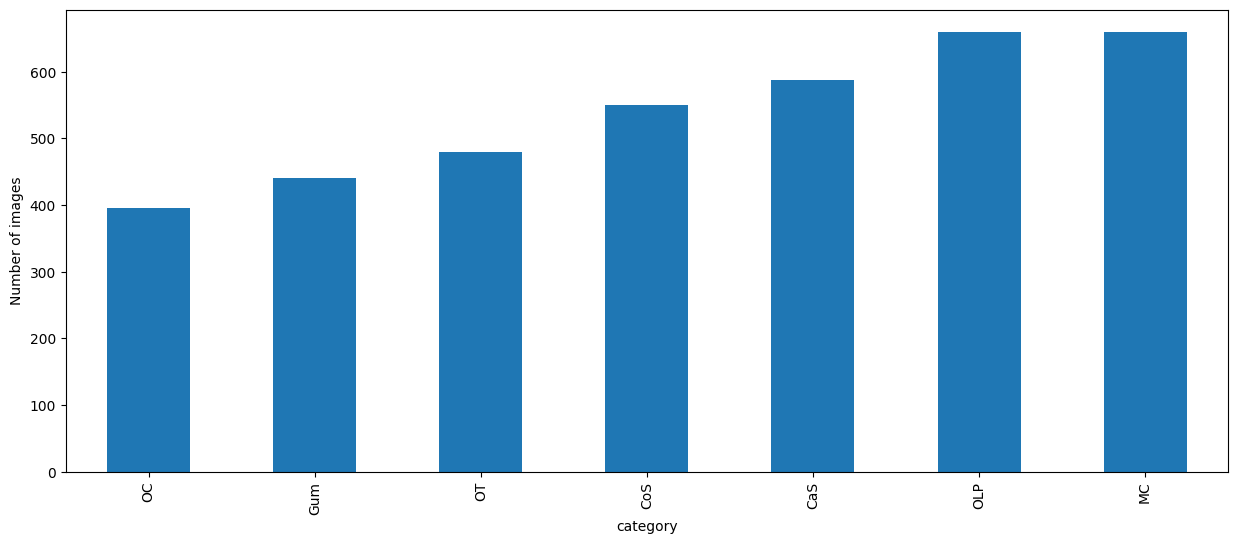

In [66]:
# create a bar plot to visualize the number of images in each folder
data_dic = {}
for folder in os.listdir(train_data):
    data_dic[folder] = len(os.listdir(train_data + '/' + folder))

data_df= pd.Series(data_dic)
plt.figure(figsize = (15, 6))
data_df.sort_values().plot(kind = 'bar')
plt.xlabel('category')
plt.ylabel('Number of images')

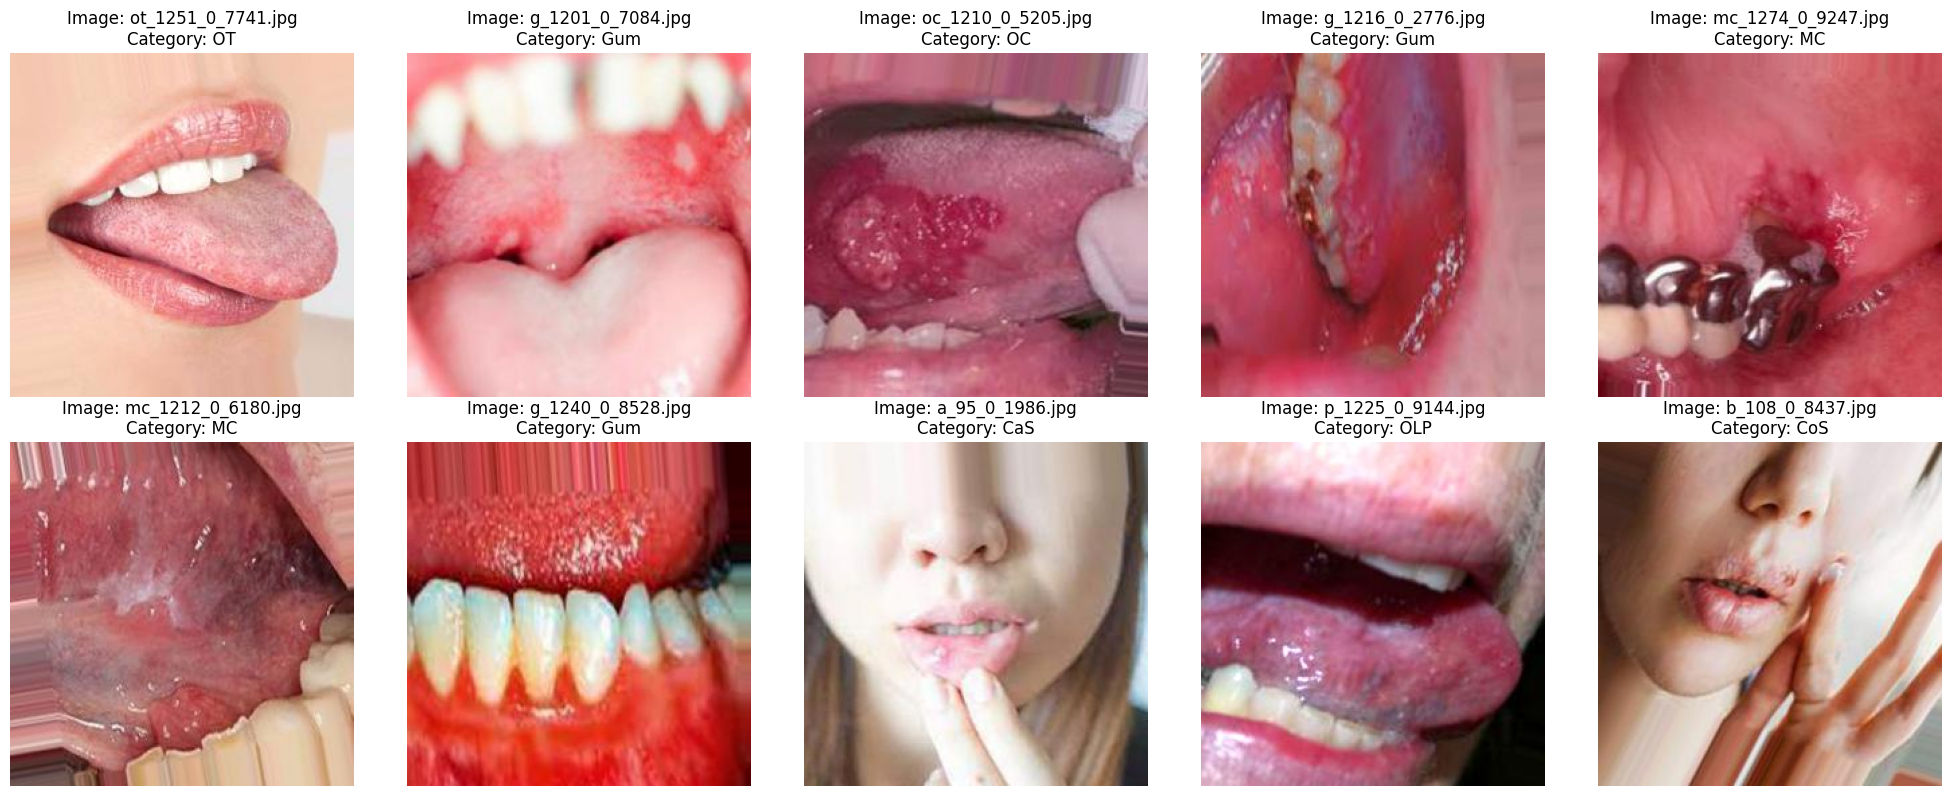

In [67]:
# Show a random collection of training file images.

def display_random_images_with_labels(df_train, class_names_label, num_images=10):

    # Randomly select images from the DataFrame
    random_images = df_train.sample(n=num_images)

    rows, cols = 2, 5  # 2 row , 5 col
    plt.figure(figsize=(20, 8))

    for i, row in enumerate(random_images.itertuples(), 1):
        img = Image.open(row.path)
        plt.subplot(rows, cols, i)
        plt.imshow(img)

        # Get name of calss from Dictionary
        category_name = [name for name, index in class_names_label.items() if index == row.category]
        category_name = category_name[0] if category_name else 'Unknown'
        plt.title(f"Image: {os.path.basename(row.path)}\nCategory: {category_name}")
        plt.axis('off')

    plt.tight_layout()  # To improve the spacing between images
    plt.show()

# Use function for display image
display_random_images_with_labels(df_train, class_names_label, num_images=10)


## Traning Generator

In [68]:
total_train = df_train.shape[0]
total_validate = df_valid.shape[0]
# batch_size=64

In [69]:
# initializeing  object with various image augmentation configurations
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

In [70]:

# setting up a data generator for training a model using image data from a dataframe

df_train['category'] = df_train['category'].astype(str)

train_generator = train_datagen.flow_from_dataframe(
    df_train,

    x_col='path',
    y_col='category',

    class_mode='categorical',
    batch_size= 16
)

Found 3773 validated image filenames belonging to 7 classes.


### Display sample of image

In [71]:
# setting up  data generator to generate augmented data for single example from dataframe
example_df = df_train.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df,
    x_col='path',
    y_col='category',
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


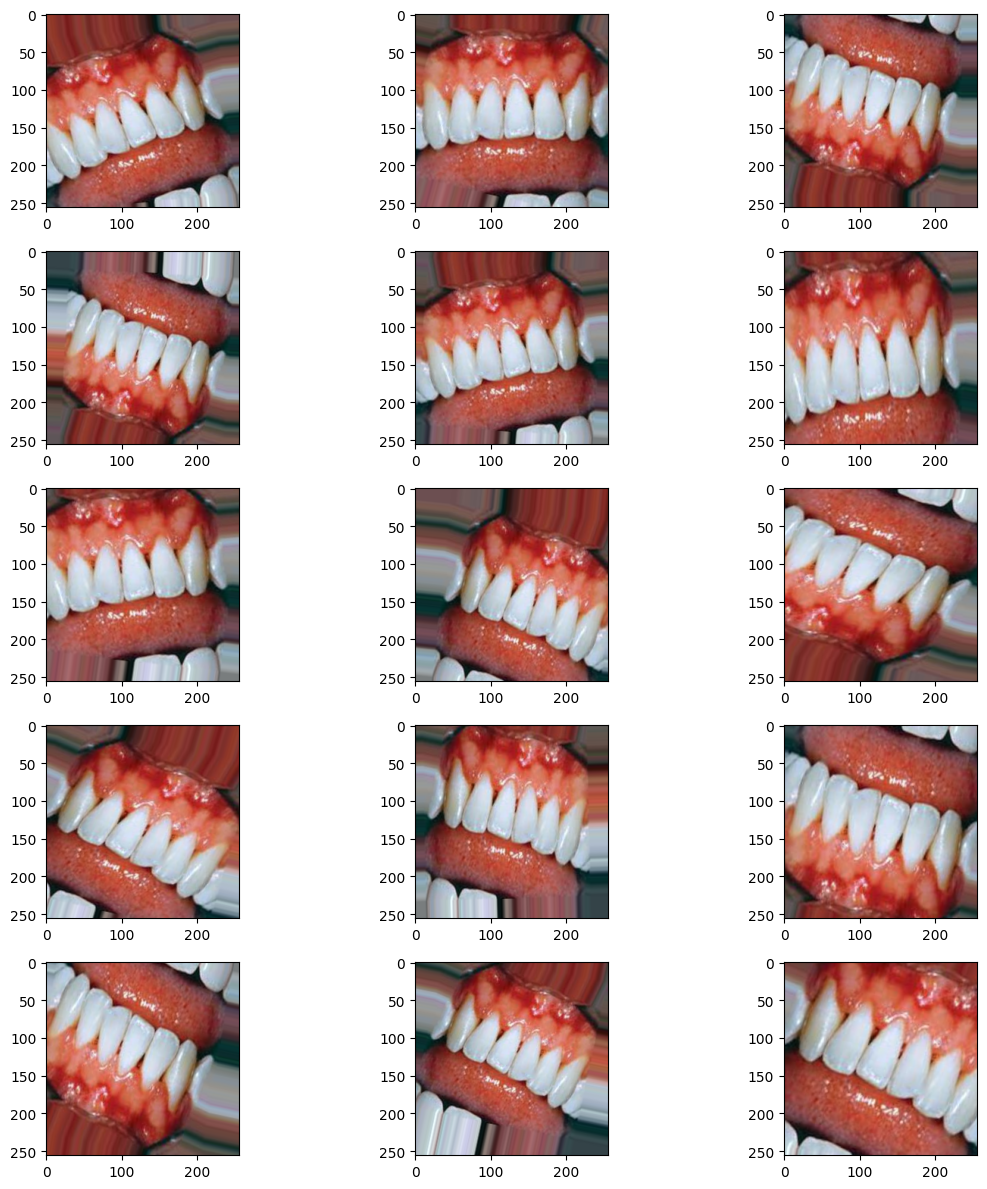

In [72]:
# generate grid of subplots to visualize augmented images
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

### Validation Generator

In [73]:
# set up a data generator for validation data
df_valid['category'] = df_valid['category'].astype(str)

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    df_valid,
    x_col='path',
    y_col='category',
    class_mode='categorical',
    batch_size= 16
)

Found 685 validated image filenames belonging to 7 classes.


##Building Model

In [74]:

model = Sequential()

# تحديد شكل المدخلات باستخدام كائن Input
model.add(Input(shape=(256, 256, 3)))

# إضافة الطبقات التلافيفية والطبقات الأخرى
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(7, activation='softmax'))




In [75]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 254, 254, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 125, 125, 128)       │          36,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 123, 123, 256)       │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 123, 123, 256)       │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 61, 61, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 61, 61, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 952576)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │     243,859,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 7)                   │           1,799 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 244,196,743 (931.54 MB)

 Trainable params: 244,195,655 (931.53 MB)

 Non-trainable params: 1,088 (4.25 KB)

In [76]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=5,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.0001)

In [77]:
earlystop = EarlyStopping(patience=7)

In [78]:
callbacks = [earlystop, learning_rate_reduction]
# save_best_model = keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/Models/fire_model',save_best_only=True) # save model
# model.fit(train_dataset,epochs=8,validation_data=test_dataset,callbacks=[save_best_model])

In [79]:
# Assuming you have already split your data into training and validation sets and loaded them into X_train, y_train, X_val, and y_val variables


batch_size=16
# Fit the model using the generators
epochs=50
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,


    callbacks=callbacks
)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


235/235 ━━━━━━━━━━━━━━━━━━━━ 84s 317ms/step - accuracy: 0.2535 - loss: 2.5990 - val_accuracy: 0.2009 - val_loss: 2.3859 - learning_rate: 0.0010
Epoch 2/50
  1/235 ━━━━━━━━━━━━━━━━━━━━ 35s 150ms/step - accuracy: 0.3750 - loss: 2.0852

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3750 - loss: 2.0852 - val_accuracy: 0.1538 - val_loss: 2.2683 - learning_rate: 0.0010
Epoch 3/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 73s 304ms/step - accuracy: 0.3876 - loss: 1.6792 - val_accuracy: 0.3527 - val_loss: 1.8189 - learning_rate: 0.0010
Epoch 4/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 186us/step - accuracy: 0.2500 - loss: 2.0573 - val_accuracy: 0.3846 - val_loss: 2.0468 - learning_rate: 0.0010
Epoch 5/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 73s 305ms/step - accuracy: 0.4558 - loss: 1.4541 - val_accuracy: 0.4926 - val_loss: 1.4701 - learning_rate: 0.0010
Epoch 6/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - accuracy: 0.3750 - loss: 1.4721 - val_accuracy: 0.3846 - val_loss: 1.5545 - learning_rate: 0.0010
Epoch 7/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 82s 304ms/step - accuracy: 0.5068 - loss: 1.3223 - val_accuracy: 0.2902 - val_loss: 2.6935 - learning_rate: 0.0010
Epoch 8/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 177us/step - accuracy: 0.5625 - loss: 1.096

## Save Model

In [80]:
# Save Model in Google Drive
model_save_path = '/content/drive/MyDrive/teeth_4.h5'

model.save(model_save_path)

print(f"Model saved to {model_save_path}")


Model saved to /content/drive/MyDrive/teeth_4.h5


In [81]:
# Load Model
model = load_model('/content/drive/MyDrive/teeth_4.h5')

## Create Testing Generator

In [82]:
# Make Data Frame with number of classes for valid folders
test_data = '/content/Teeth_NewDataset/Testing'

rows = []

for folder in os.listdir(test_data):
    path = os.path.join(test_data, folder, '*.jpg')
    image_paths = glob.glob(path)
    for image_path in image_paths:
        # احصل على التصنيف الرقمي من القاموس باستخدام اسم المجلد
        category = class_names_label.get(folder, 'unknown')  # استخدم 'unknown' إذا كان اسم المجلد غير موجود
        rows.append({'path': image_path, 'category': category})

df_test = pd.DataFrame(rows)

In [83]:
df_test['category'] = df_test['category'].astype(str)  # تحويل الفئات إلى نصوص إذا لزم الأمر


In [84]:
# set up a data generator for test data
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    dataframe=df_test,
    x_col='path',
    y_col='category',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 685 validated image filenames belonging to 7 classes.


In [85]:
evaluation = model.evaluate(test_generator)
print(f"Test Loss: {evaluation[0]}")
print(f"Test Accuracy: {evaluation[1]}")


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 0.8357 - loss: 0.4596
Test Loss: 0.38692474365234375
Test Accuracy: 0.8656934499740601


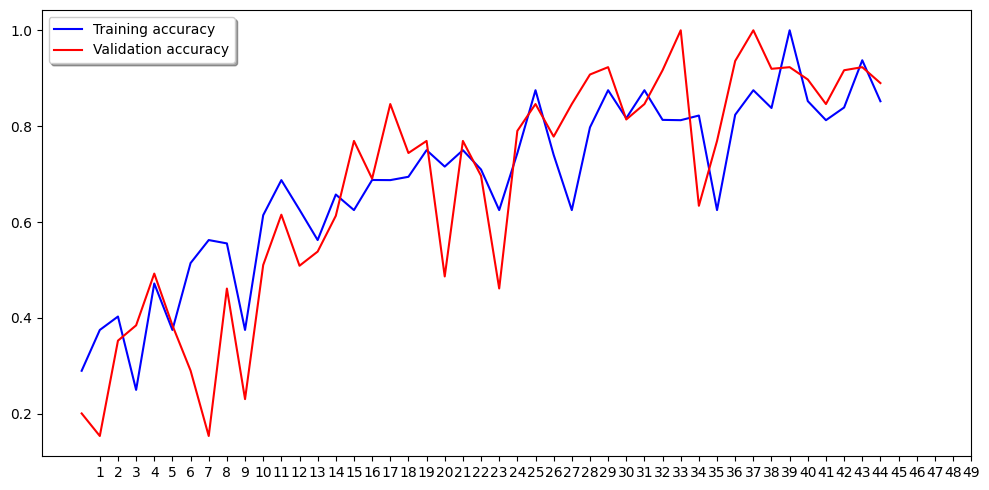

In [86]:
fig, ( ax2) = plt.subplots(1, 1, figsize=(10, 5))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [87]:
df_test


,path,category
0,/content/Teeth_NewDataset/Testing/CaS/a_125_0_...,0
1,/content/Teeth_NewDataset/Testing/CaS/a_117_0_...,0
2,/content/Teeth_NewDataset/Testing/CaS/a_122_0_...,0
3,/content/Teeth_NewDataset/Testing/CaS/a_156_0_...,0
4,/content/Teeth_NewDataset/Testing/CaS/a_142_0_...,0
...,...,...
680,/content/Teeth_NewDataset/Testing/Gum/g_1210_0...,6
681,/content/Teeth_NewDataset/Testing/Gum/g_1258.jpg,6
682,/content/Teeth_NewDataset/Testing/Gum/g_1228_0...,6
683,/content/Teeth_NewDataset/Testing/Gum/g_1233_0...,6


## drawing confusion matrix

43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step 


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


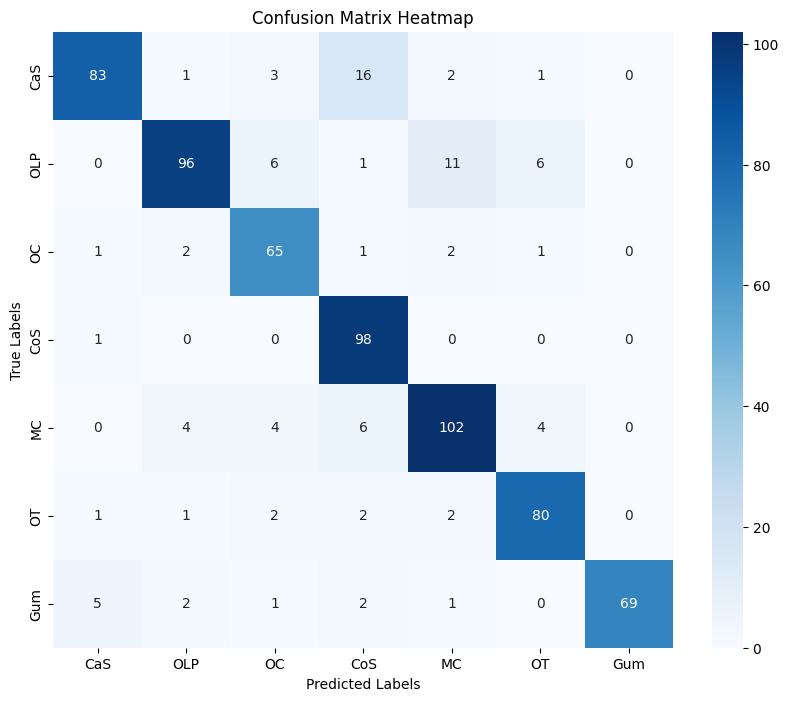

In [88]:

nb_samples = test_generator.n

predict = model.predict(test_generator, steps=int(np.ceil(nb_samples/batch_size)))

# تحويل التوقعات إلى الفئات المتوقعة
predicted_classes = np.argmax(predict, axis=1)

# الحصول على الفئات الحقيقية من مولد البيانات
true_classes = test_generator.classes

conf_matrix = confusion_matrix(true_classes, predicted_classes)

# إعداد أسماء الفئات
class_names = list(class_names_label.keys())

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()
